In [20]:
import keras
keras.backend.backend()

'theano'

In [21]:
from sklearn import preprocessing
import numpy as np
from readers.data_reader import Dataset
from experiments.emotion_flow_exp import ExperimentSentimentAttentionMT
import sys
from sklearn.metrics import f1_score

In [22]:
model_root='../models/'

model='sf_mt_50_checked_model.hdf5'

param={'recurrent_units': 64, 'recurrent_dropout': 0.3, 'recurrent_activation': 'tanh', 'patience': 25, 
       'lr': 0.001, 'initializer': 'lecun_uniform', 'genre_emb_size': 32, 'epochs': 100, 'dropout_1': 0.2,
       'dropout': 0.2, 'batch_size': 1, 'attention_units': 64}

In [23]:
feature_lst=['nrc_mean_sd_50_all'] 

dataset = Dataset(features=feature_lst, label_extractor='success_genre', genre=False)

In [24]:
X_train, Y_train = dataset.get_training_data()
X_val, Y_val = dataset.get_validaiontion_data()
X_test, Y_test = dataset.get_test_data()

le = preprocessing.LabelEncoder()

Y_train['success_output'] = le.fit_transform(Y_train['success_output'])
Y_val['success_output'] = le.transform(Y_val['success_output'])
Y_test['success_output'] = le.transform(Y_test['success_output'])

Y_test_books=dataset.info['test_books']
Y_test_Genre= dataset.info['Y_test'][:,1]

In [25]:
for feature in set(feature_lst) :
    print("Feature: {}".format(feature))
    print("Traning shape {}:{}".format(feature, X_train[feature].shape))
    print("Val shape {}:{}".format(feature, X_val[feature].shape))
    print("Test shape {}:{}".format(feature, X_test[feature].shape))
    print()

Feature: nrc_mean_sd_50_all
Traning shape nrc_mean_sd_50_all:(555, 50, 20)
Val shape nrc_mean_sd_50_all:(139, 50, 20)
Test shape nrc_mean_sd_50_all:(290, 50, 20)



In [26]:
Y_test_books[:5]

['24875_lucy+maud+montgomery+short+stories+1904.txt',
 '26060_complete+version+of+ye+three+blind+mice.txt',
 '23162_no+great+magic.txt',
 '1257_the+three+musketeers.txt',
 '2059_the+little+shepherd+of+kingdom+come.txt']

In [27]:
Y_test_Genre[:5]

array(['Short_stories', 'Poetry', 'Science_fiction', 'Historical_fiction',
       'Historical_fiction'], dtype=object)

###  Load model and predict

In [28]:
experiment = ExperimentSentimentAttentionMT(train_Xs=X_train, train_Ys=Y_train, val_Xs=X_val, val_Ys=Y_val,
                                          test_Xs=X_test,
                                          test_Ys=Y_test, le=le,
                                          params=param,
                                          name='att_MT_')

In [29]:
exp_model_path=model_root+model
experiment.predict(checked_model_path=exp_model_path,settings=param)

/anaconda3/lib/python3.6/site-packages/keras/layers/recurrent.py:1550: UserWarning: RNN dropout is no longer supported with the Theano backend due to technical limitations. You can either set `dropout` and `recurrent_dropout` to 0, or use the TensorFlow backend.
  'RNN dropout is no longer supported with the Theano backend '


MT prediction task
F1 Weighted Score: 0.6896466217917353


In [30]:
from keras.models import load_model

model=experiment.create_model(param)
model.load_weights(exp_model_path)
Y_test_pred = model.predict(X_test)
if len(Y_test_pred) == 2:
    print("MT prediction task")
    Y_test_pred = Y_test_pred[0].flatten()
Y_test_pred = np.array([1 if y > 0.5 else 0 for y in Y_test_pred])

print ("F1 Weighted Score: {}".format(f1_score(Y_test['success_output'].flatten(),
                                          Y_test_pred.flatten(), average='weighted', pos_label=None)))

/anaconda3/lib/python3.6/site-packages/keras/layers/recurrent.py:1550: UserWarning: RNN dropout is no longer supported with the Theano backend due to technical limitations. You can either set `dropout` and `recurrent_dropout` to 0, or use the TensorFlow backend.
  'RNN dropout is no longer supported with the Theano backend '


MT prediction task
F1 Weighted Score: 0.6896466217917353


## Analysis

### Attention

In [33]:
for layer in model.layers:
    print (layer)

In [34]:
from keras import backend as K

inputs=X_train.keys()
print (inputs)

dict_keys(['nrc_mean_sd_50_all'])


In [35]:
## function to extract attention weights
attention_func = K.function([model.get_layer(function_in).input for function_in in inputs]+[ K.learning_phase()], [model.layers[2].attention_param])
attention = attention_func([X_test[function_in]  for function_in in inputs]+[ 0])[0]

In [36]:
attention.shape

(290, 50)

In [37]:
import pandas as pd
columns= ['chunk_{}'.format(i) for i in range(50)]
df=pd.DataFrame(attention, columns=columns)

In [38]:
df.head()

,chunk_0,chunk_1,chunk_2,chunk_3,chunk_4,chunk_5,chunk_6,chunk_7,chunk_8,chunk_9,...,chunk_40,chunk_41,chunk_42,chunk_43,chunk_44,chunk_45,chunk_46,chunk_47,chunk_48,chunk_49
0,1.001969e-10,9.844875e-11,2.222465e-10,1.884822e-10,2.149494e-10,3.222910e-10,1.207343e-09,1.174658e-09,3.416601e-09,1.006440e-09,...,1.957075e-08,6.826253e-08,5.851446e-08,8.425395e-07,1.925626e-06,2.676101e-05,1.598399e-05,3.012401e-04,7.863758e-01,2.132766e-01
1,5.936199e-18,1.180396e-17,5.123093e-15,1.170824e-14,5.246900e-02,4.265979e-08,9.468169e-01,4.232991e-04,2.507066e-15,3.160844e-18,...,5.251179e-19,2.275957e-19,2.079196e-18,1.056391e-17,1.328138e-17,1.853267e-17,2.849644e-17,8.916560e-18,3.076869e-15,3.907252e-08
2,4.327988e-11,6.193198e-11,2.441042e-11,4.271535e-10,5.340319e-10,1.590431e-09,8.057023e-10,1.478734e-07,7.094236e-09,1.284879e-09,...,5.666903e-07,3.287806e-07,5.805897e-06,1.668260e-06,1.396624e-05,6.995697e-03,2.856691e-04,2.217593e-03,4.600908e-02,9.441855e-01
3,1.549762e-09,1.660883e-09,1.963961e-09,6.666777e-10,1.490872e-09,4.597545e-09,6.157264e-10,2.063969e-09,1.004824e-09,1.729201e-09,...,9.419564e-05,4.094535e-05,4.788850e-05,7.979377e-06,9.768696e-05,1.429257e-04,4.404096e-05,5.918711e-04,1.213887e-01,8.775212e-01
4,1.370869e-08,3.365699e-06,6.699359e-08,8.825647e-08,3.121560e-05,1.356873e-07,6.074293e-08,2.523069e-08,5.696003e-09,2.376223e-09,...,2.019912e-05,2.747540e-04,1.841969e-04,9.816614e-05,3.055416e-04,2.647441e-03,1.746789e-04,1.567965e-01,4.354702e-02,7.958477e-01


#### ADD the book title, genre and success labels to the df

In [39]:
df['Book']=Y_test_books
df['Genre']=Y_test_Genre
df['Actual']=Y_test['success_output'].flatten()
df['Predicted']=Y_test_pred

In [40]:
df.head()

,chunk_0,chunk_1,chunk_2,chunk_3,chunk_4,chunk_5,chunk_6,chunk_7,chunk_8,chunk_9,...,chunk_44,chunk_45,chunk_46,chunk_47,chunk_48,chunk_49,Book,Genre,Actual,Predicted
0,1.001969e-10,9.844875e-11,2.222465e-10,1.884822e-10,2.149494e-10,3.222910e-10,1.207343e-09,1.174658e-09,3.416601e-09,1.006440e-09,...,1.925626e-06,2.676101e-05,1.598399e-05,3.012401e-04,7.863758e-01,2.132766e-01,24875_lucy+maud+montgomery+short+stories+1904.txt,Short_stories,1,1
1,5.936199e-18,1.180396e-17,5.123093e-15,1.170824e-14,5.246900e-02,4.265979e-08,9.468169e-01,4.232991e-04,2.507066e-15,3.160844e-18,...,1.328138e-17,1.853267e-17,2.849644e-17,8.916560e-18,3.076869e-15,3.907252e-08,26060_complete+version+of+ye+three+blind+mice.txt,Poetry,0,1
2,4.327988e-11,6.193198e-11,2.441042e-11,4.271535e-10,5.340319e-10,1.590431e-09,8.057023e-10,1.478734e-07,7.094236e-09,1.284879e-09,...,1.396624e-05,6.995697e-03,2.856691e-04,2.217593e-03,4.600908e-02,9.441855e-01,23162_no+great+magic.txt,Science_fiction,0,0
3,1.549762e-09,1.660883e-09,1.963961e-09,6.666777e-10,1.490872e-09,4.597545e-09,6.157264e-10,2.063969e-09,1.004824e-09,1.729201e-09,...,9.768696e-05,1.429257e-04,4.404096e-05,5.918711e-04,1.213887e-01,8.775212e-01,1257_the+three+musketeers.txt,Historical_fiction,1,1
4,1.370869e-08,3.365699e-06,6.699359e-08,8.825647e-08,3.121560e-05,1.356873e-07,6.074293e-08,2.523069e-08,5.696003e-09,2.376223e-09,...,3.055416e-04,2.647441e-03,1.746789e-04,1.567965e-01,4.354702e-02,7.958477e-01,2059_the+little+shepherd+of+kingdom+come.txt,Historical_fiction,1,1


#### Group by genre

In [41]:
genre_mean=df.groupby('Genre').mean()

In [52]:
from sklearn.preprocessing import normalize,minmax_scale

genre_norm_df=genre_mean.copy()
genre_norm_df[columns]=normalize(genre_mean[columns],axis=1, norm='max')

columns_plot= [x.replace('chunk_','') for x in columns]
genre_norm_df.rename(columns=dict(zip(columns,columns_plot)), inplace=True)

Text(0.5,15,'Chunks')

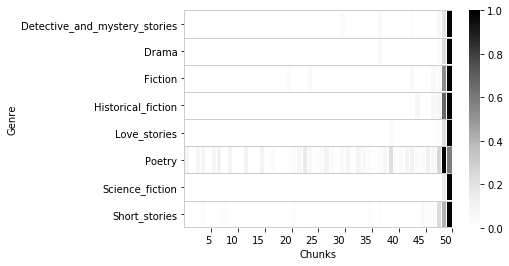

In [53]:

ax=sns.heatmap(genre_norm_df[columns_plot],linewidths=0.05,cmap='Greys',vmin=0, vmax=1,fmt="d",center=0.5)
# cbar = ax.figure.colorbar(ax.collections[0])
# cbar(aspect=20)
ax.hlines([0, 1, 2,3,4,5,6,7], colors='#cdcdcd', linewidth=1, *ax.get_xlim())
ax.axvline(0, linewidth=1, c='#cdcdcd')
ax.axhline(8, linewidth=3, c='#cdcdcd')
# ax.axhline(8, linewidth=3, c='b')

ax.set_xticklabels(ax.get_xticklabels(),rotation=0,ha='right')
ax.set_ylabel('Genre')
ax.set(xticks=[5,10,15,20,25,30,35,40,45,50], xticklabels=[5,10,15,20,25,30,35,40,45,50])
#ax.set_xticklabels([0,5,10,15,20,25,30,35,45,49])
ax.set_xlabel('Chunks')
# ax.set_aspect("equal")